# Heterogeneous Quadratic Benchmark

Reproduces **Figure 4** from the paper *"On Surprising Effectiveness of Masking Updates in Adaptive Optimizers"* (arXiv 2602.15322).
This should show that Magma improves convergence on quadratic problems with *heterogeneous* curvature across blocks, but provides no benefit on *homogeneous* curvature.

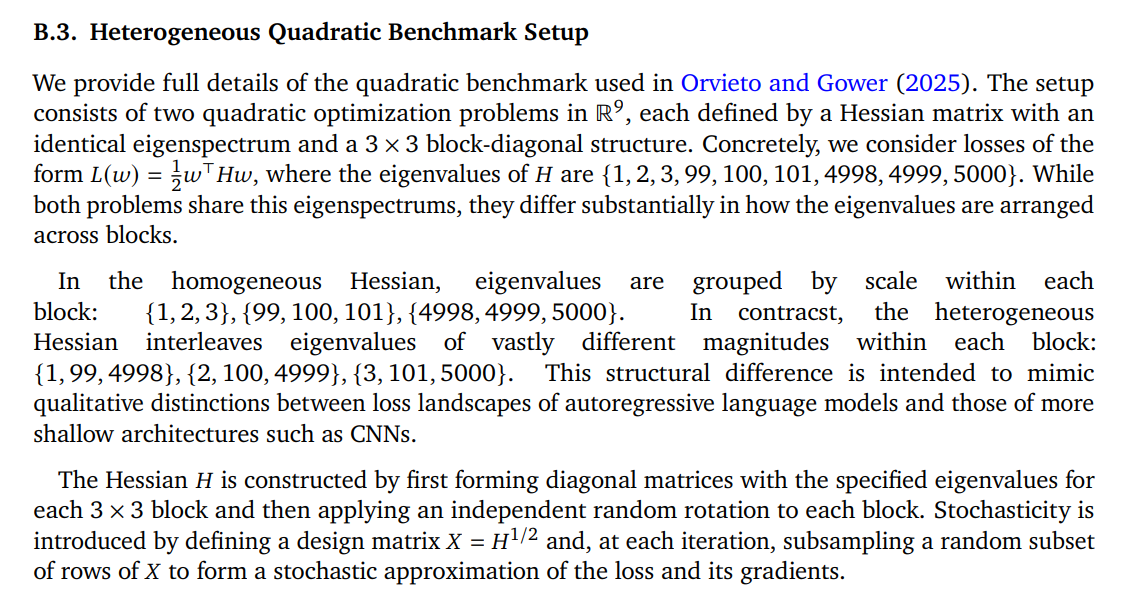

In [10]:
!pip install -q git+https://github.com/andrijdavid/magma-optimizer.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [11]:
import torch
import matplotlib.pyplot as plt
from magma import Magma

torch.manual_seed(123456789)

In [12]:
def make_block_diagonal_hessian(eigenvalues_per_block):
    """Create a block-diagonal PSD matrix from eigenvalue lists.
    
    Each block is 3x3, constructed via random orthogonal basis.
    """
    blocks = []
    for eigs in eigenvalues_per_block:
        # Random orthogonal matrix for this block
        Q, _ = torch.linalg.qr(torch.randn(3, 3))
        D = torch.diag(torch.tensor(eigs, dtype=torch.float32))
        blocks.append(Q @ D @ Q.T)
    return torch.block_diag(*blocks)


# Homogeneous: similar eigenvalues within each block
H_homo = make_block_diagonal_hessian([
    [1.0, 2.0, 3.0],
    [99.0, 100.0, 101.0],
    [4998.0, 4999.0, 5000.0],
])

# Heterogeneous: diverse eigenvalues within each block
H_hetero = make_block_diagonal_hessian([
    [1.0, 99.0, 4998.0],
    [2.0, 100.0, 4999.0],
    [3.0, 101.0, 5000.0],
])

print("Homogeneous eigenvalues:", torch.linalg.eigvalsh(H_homo).tolist())
print("Heterogeneous eigenvalues:", torch.linalg.eigvalsh(H_hetero).tolist())

Homogeneous eigenvalues: [1.0000003576278687, 2.0, 2.999999761581421, 99.0, 100.0000228881836, 101.0, 4998.00048828125, 4998.9990234375, 4999.9990234375]
Heterogeneous eigenvalues: [0.9998701810836792, 2.000009298324585, 2.9997637271881104, 98.99996948242188, 100.0001220703125, 100.99994659423828, 4997.99951171875, 4999.0, 4999.99951171875]


In [13]:
def run_quadratic_optim(H, optimizer_cls, magma_wrap, steps=2000, lr=1e-3, runs=10, batch_rows=3):
    """Minimize L(w)=0.5 * w^T H w and return mean loss curve over runs.

    Paper Appendix B.3 uses a stochastic surrogate: define X = H^(1/2),
    then subsample rows of X at each step
    """
    d = H.shape[0]

    # We construct X so H is approx X@X as per paper definition X is H^(1/2)
    # This is needed 
    evals, evecs = torch.linalg.eigh(H)
    evals = torch.clamp(evals, min=0.0)
    X = (evecs * torch.sqrt(evals)) @ evecs.T

    all_losses = []
    for seed in range(runs):
        torch.manual_seed(seed)
        
        params = [torch.randn(3, requires_grad=True) for _ in range(3)]

        base_opt = optimizer_cls(params, lr=lr)
        opt = Magma(base_opt, mask_prob=0.5, tau=2.0) if magma_wrap else base_opt

        losses = []
        eval_losses = []
        for _ in range(steps):
            opt.zero_grad()
            w = torch.cat(params)

            # Random sampling as explained in the paper
            rows = torch.randperm(d)[:batch_rows]
            Xb = X[rows]
            scale = d / float(batch_rows)
            loss = 0.5 * scale * (Xb @ w).pow(2).sum()

            loss.backward()
            opt.step()
            losses.append(loss.item())
            with torch.no_grad():
                w_eval = torch.cat(params)
                eval_loss = 0.5 * (w_eval @ H @ w_eval)
                eval_losses.append(eval_loss.item())
        all_losses.append((losses, eval_losses))

    return torch.tensor(all_losses).mean(dim=0).numpy()


In [14]:
steps = 2000
lrs = [3e-3, 1e-2, 3e-2, 0.1]
runs = 5

configs = [
    ("Adam", torch.optim.Adam, False),
    ("Adam+Magma", torch.optim.Adam, True),
    ("RMSProp", torch.optim.RMSprop, False),
    ("RMSProp+Magma", torch.optim.RMSprop, True),
]

results = {}
for label, opt_cls, use_magma in configs:
    for name, H in [("Homogeneous", H_homo), ("Heterogeneous", H_hetero)]:
        for lr in lrs:
            key = f"{label} ({name}) lr={lr}"
            print(f"Running {key}...")
            results[(label, name, lr)] = run_quadratic_optim(
                H, opt_cls, use_magma, steps=steps, lr=lr, runs=runs
            )

Running Adam (Homogeneous) lr=0.003...
Running Adam (Homogeneous) lr=0.01...
Running Adam (Homogeneous) lr=0.03...
Running Adam (Homogeneous) lr=0.1...
Running Adam (Heterogeneous) lr=0.003...
Running Adam (Heterogeneous) lr=0.01...
Running Adam (Heterogeneous) lr=0.03...
Running Adam (Heterogeneous) lr=0.1...
Running Adam+Magma (Homogeneous) lr=0.003...
Running Adam+Magma (Homogeneous) lr=0.01...
Running Adam+Magma (Homogeneous) lr=0.03...
Running Adam+Magma (Homogeneous) lr=0.1...
Running Adam+Magma (Heterogeneous) lr=0.003...
Running Adam+Magma (Heterogeneous) lr=0.01...
Running Adam+Magma (Heterogeneous) lr=0.03...
Running Adam+Magma (Heterogeneous) lr=0.1...
Running RMSProp (Homogeneous) lr=0.003...
Running RMSProp (Homogeneous) lr=0.01...
Running RMSProp (Homogeneous) lr=0.03...
Running RMSProp (Homogeneous) lr=0.1...
Running RMSProp (Heterogeneous) lr=0.003...
Running RMSProp (Heterogeneous) lr=0.01...
Running RMSProp (Heterogeneous) lr=0.03...
Running RMSProp (Heterogeneous) lr

In [15]:

colors = {
    ('Adam', 0.003): '#185c8b',
    ('Adam', 0.01): '#2282c5',
    ('Adam', 0.03): '#4ba3e0',
    ('Adam', 0.1): '#85c1ea',

    ('Adam+Magma', 0.003): '#a34d00',
    ('Adam+Magma', 0.01): '#e76c00',
    ('Adam+Magma', 0.03): '#ff8f2c',
    ('Adam+Magma', 0.1): '#ffb370',

    ('RMSProp', 0.003): '#238023',
    ('RMSProp', 0.01): '#32b532',
    ('RMSProp', 0.03): '#5ad25a',
    ('RMSProp', 0.1): '#8fe08f',

    ('RMSProp+Magma', 0.003): '#8a191a',
    ('RMSProp+Magma', 0.01): '#c42425',
    ('RMSProp+Magma', 0.03): '#df4d4e',
    ('RMSProp+Magma', 0.1): '#e98687',
}
styles = {"Adam": "--", "Adam+Magma": "-", "RMSProp": "--", "RMSProp+Magma": "-"}

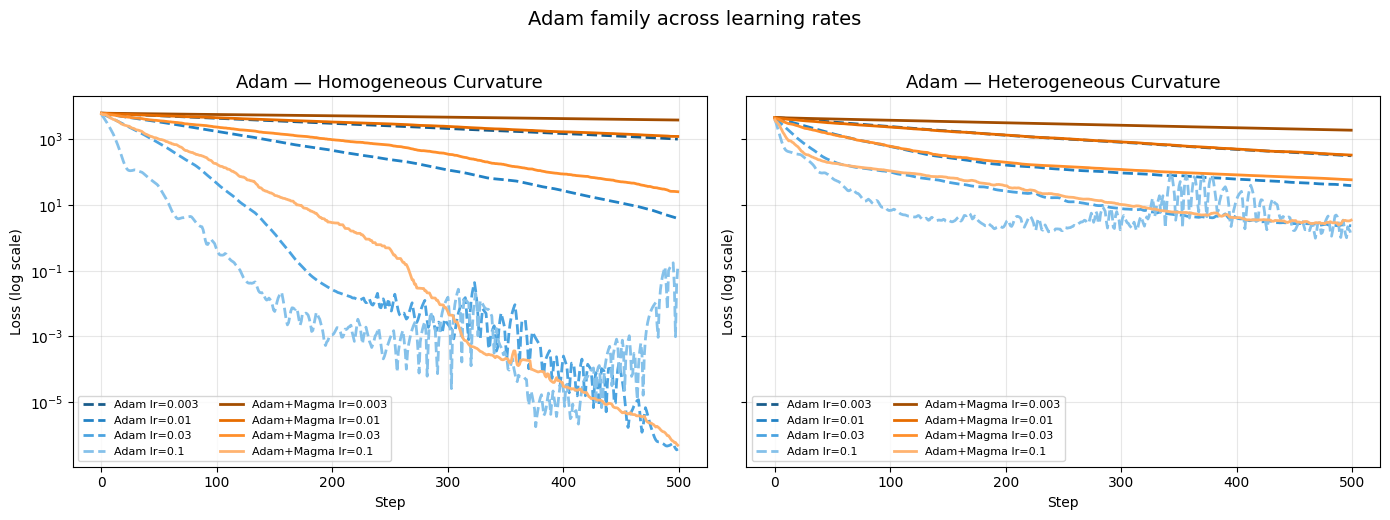

In [16]:
optimizer_families = {
    "Adam": ["Adam", "Adam+Magma"],
    "RMSProp": ["RMSProp", "RMSProp+Magma"],
}

def plot_family(family_name, labels, save_name, max_steps=steps):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True, sharey=True)

    for i, setting in enumerate(["Homogeneous", "Heterogeneous"]):
        ax = axes[i]

        for label in labels:
            for lr in lrs:
                curve = results[(label, setting, lr)][-1][:max_steps]
                ax.semilogy(
                    curve,
                    label=f"{label} lr={lr:g}",
                    color=colors[(label, lr)],
                    linestyle=styles[label],
                    linewidth=2,
                )

        ax.set_title(f"{family_name} — {setting} Curvature", fontsize=13)
        ax.set_xlabel("Step")
        ax.set_ylabel("Loss (log scale)")
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8, ncol=2)

    fig.suptitle(f"{family_name} family across learning rates", fontsize=14, y=1.03)
    plt.tight_layout()
    plt.savefig(save_name, dpi=150, bbox_inches="tight")
    plt.show()

plot_family("Adam", optimizer_families["Adam"], "quadratic_benchmark_adam.png", max_steps=500)

The result from the paper
 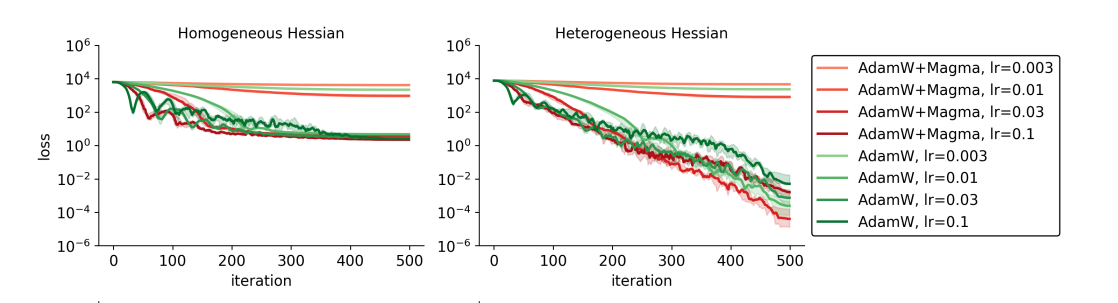

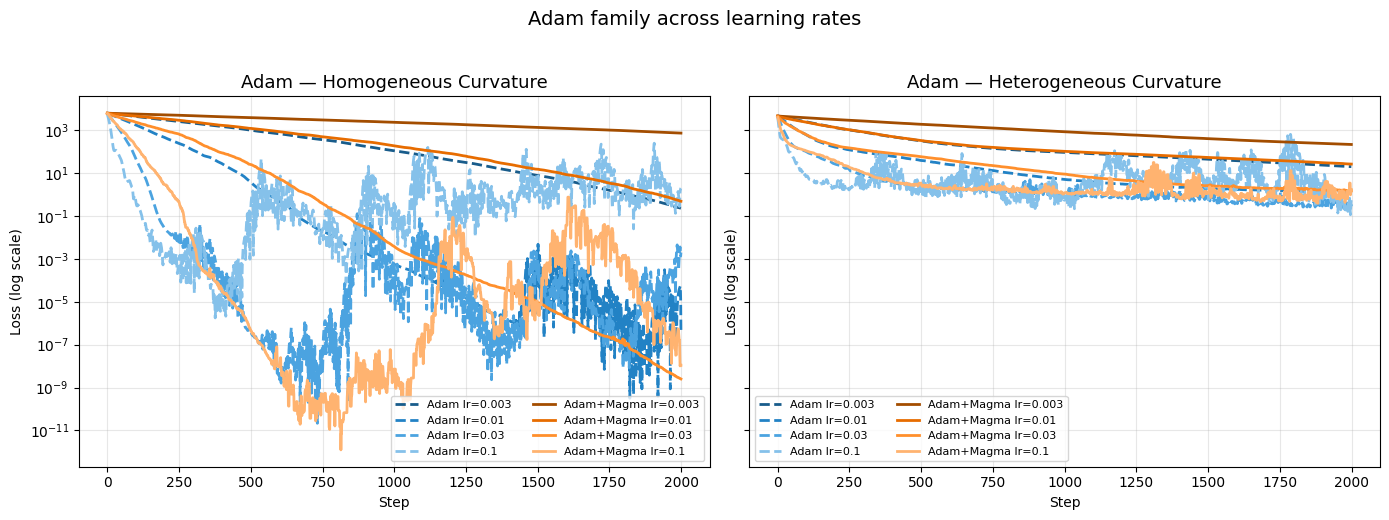

In [17]:
plot_family("Adam", optimizer_families["Adam"], "quadratic_benchmark_adam.png")

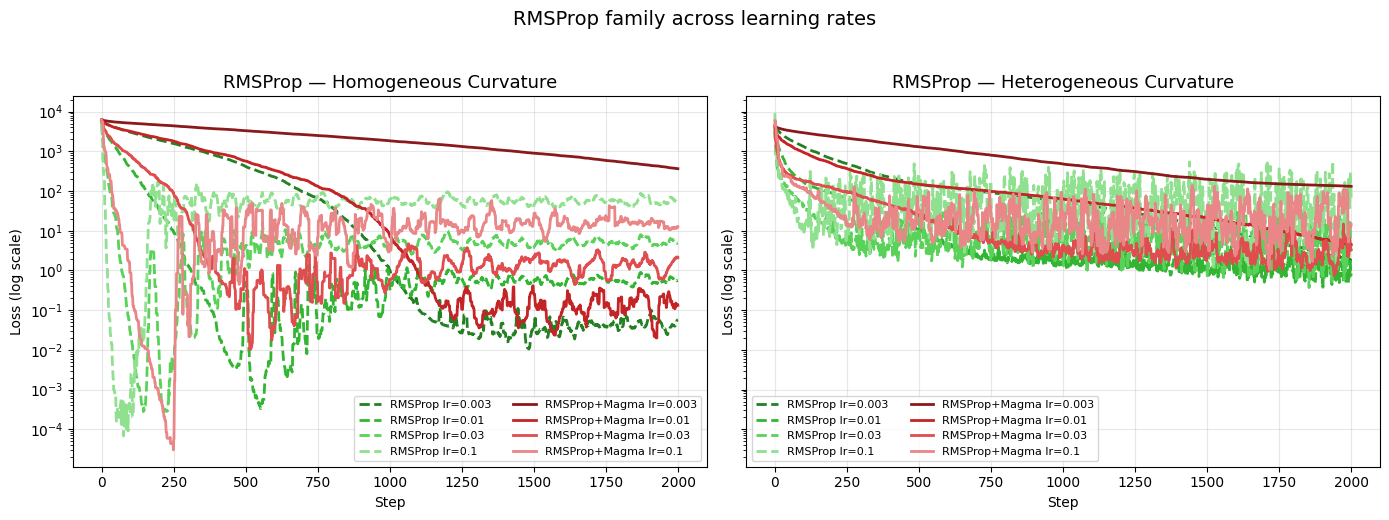

In [18]:
plot_family("RMSProp", optimizer_families["RMSProp"], "quadratic_benchmark_rmsprop.png")